## Model Evaluation Pipeline: Performance Analysis & Visualization

This notebook handles comprehensive model evaluation and analysis:

1. **Setup & Model Loading** - Load the trained model and datasets
2. **Prediction Generation** - Generate predictions on validation and test sets
3. **Performance Metrics** - Macro/micro precision, recall, F1-score
4. **Confusion Matrix Analysis** - Visualize classification patterns and errors
5. **Per-Class Analysis** - F1-score for each enzyme class
6. **Error Analysis** - Examine misclassified examples
7. **Results Visualization** - Interactive plots and comprehensive reports

### Import Libraries

In [1]:
import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from transformers import (
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from peft import PeftModel
from datasets import load_from_disk
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
    f1_score
)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 1. Setup & Configuration

In [2]:
# Load configuration
print("=" * 70)
print("EVALUATION SETUP")
print("=" * 70)

project_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent
config_path = project_root / "config.yaml"

with open(config_path) as f:
    cfg = yaml.safe_load(f)

# Convert all paths to Path objects
paths = {
    'raw': project_root / cfg['data']['paths']['raw'],
    'processed': project_root / cfg['data']['paths']['processed'],
    'tokenized': project_root / cfg['data']['paths']['tokenized'],
    'checkpoints': project_root / cfg['paths']['checkpoints'],
    'results': project_root / cfg['paths']['results'],
    'final_model': project_root / cfg['paths']['final_model']
}

print("\nConfiguration loaded:")
print(f"  Project: {cfg['project']['name']}")
print(f"  Model: {cfg['model']['name']}")
print(f"  Number of classes: {cfg['model']['num_labels']}")

# EC class names
ec_names = [
    "Oxidoreductases",
    "Transferases",
    "Hydrolases",
    "Lyases",
    "Isomerases",
    "Ligases",
    "Translocases"
]

ec_names_short = ["Oxido", "Trans", "Hydro", "Lyase", "Isom", "Ligase", "Transl"]

print("\n✓ Setup complete")

EVALUATION SETUP

Configuration loaded:
  Project: enzyme-classification-esm2
  Model: facebook/esm2_t12_35M_UR50D
  Number of classes: 7

✓ Setup complete


In [3]:
# Create output directories
print("\n=== CREATING OUTPUT DIRECTORIES ===")

output_dirs = [
    paths['results'] / 'predictions',
    paths['results'] / 'figures',
    paths['results'] / 'metrics'
]

for dir_path in output_dirs:
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"  ✓ {dir_path}")

print("\n✓ Output directories ready")


=== CREATING OUTPUT DIRECTORIES ===
  ✓ c:\Users\calam\repos\enzyme_classifier\results\predictions
  ✓ c:\Users\calam\repos\enzyme_classifier\results\figures
  ✓ c:\Users\calam\repos\enzyme_classifier\results\metrics

✓ Output directories ready


In [4]:
# Check device
print("\n=== DEVICE CHECK ===")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


=== DEVICE CHECK ===
Using device: cuda
GPU: NVIDIA GeForce RTX 5060
Memory: 8.55 GB


## 2. Load Model & Datasets

In [5]:
print("\n=== LOADING TRAINED MODEL ===")

# Use final model path from config
model_path = paths['final_model']

if not model_path.exists():
    print(f"❌ Error: Model not found at {model_path}")
    print("Please run 02_training.ipynb first to train the model.")
else:
    print(f"Loading model from: {model_path}")

    # Load base pre-trained model
    base_model = AutoModelForSequenceClassification.from_pretrained(
        cfg["model"]["name"],
        num_labels=cfg["model"]["num_labels"],
        trust_remote_code=True,
    )

    # Load LoRA adapters on top
    model = PeftModel.from_pretrained(base_model, str(model_path))
    model = model.to(device)
    model.eval()

    print("✓ Model loaded successfully")
    print(f"  Model on device: {next(model.parameters()).device}")


=== LOADING TRAINED MODEL ===
Loading model from: c:\Users\calam\repos\enzyme_classifier\models\final_model


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully
  Model on device: cuda:0


In [6]:
print("\n=== LOADING DATASETS ===")

# Load tokenized datasets
val_path = paths['tokenized'] / 'val_dataset'
test_path = paths['tokenized'] / 'test_dataset'

print(f"Loading validation dataset from: {val_path}")
val_ds = load_from_disk(str(val_path)).with_format("torch")

print(f"Loading test dataset from: {test_path}")
test_ds = load_from_disk(str(test_path)).with_format("torch")

print("\n=== DATASET SUMMARY ===")
print(f"Validation samples: {len(val_ds):,}")
print(f"Test samples: {len(test_ds):,}")

print("\n✓ Datasets loaded successfully")


=== LOADING DATASETS ===
Loading validation dataset from: c:\Users\calam\repos\enzyme_classifier\data\tokenized\val_dataset
Loading test dataset from: c:\Users\calam\repos\enzyme_classifier\data\tokenized\test_dataset

=== DATASET SUMMARY ===
Validation samples: 23,879
Test samples: 23,879

✓ Datasets loaded successfully


## 3. Generate Predictions

In [7]:
# Setup trainer for prediction
print("\n=== SETTING UP TRAINER FOR EVALUATION ===")

# Minimal training arguments for evaluation
eval_args = TrainingArguments(
    output_dir=str(paths['checkpoints'] / 'eval_temp'),
    per_device_eval_batch_size=cfg['training']['batch_size'],
    dataloader_num_workers=cfg['training']['num_workers'],
)

trainer = Trainer(
    model=model,
    args=eval_args,
)

print("✓ Trainer configured for evaluation")


=== SETTING UP TRAINER FOR EVALUATION ===
✓ Trainer configured for evaluation


In [8]:
# Generate predictions on validation set
print("\n=== GENERATING VALIDATION PREDICTIONS ===")

val_predictions = trainer.predict(val_ds)
val_logits = val_predictions.predictions
val_pred_labels = val_logits.argmax(-1)
val_true_labels = val_predictions.label_ids

# Get prediction probabilities
val_probs = torch.softmax(torch.tensor(val_logits), dim=-1).numpy()
val_confidence = val_probs.max(-1)

print(f"✓ Generated predictions for {len(val_pred_labels):,} validation samples")
print(f"  Prediction shape: {val_logits.shape}")


=== GENERATING VALIDATION PREDICTIONS ===


wandb: Currently logged in as: cristinalee0723 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ Generated predictions for 23,879 validation samples
  Prediction shape: (23879, 7)


In [9]:
# Generate predictions on test set
print("\n=== GENERATING TEST PREDICTIONS ===")

test_predictions = trainer.predict(test_ds)
test_logits = test_predictions.predictions
test_pred_labels = test_logits.argmax(-1)
test_true_labels = test_predictions.label_ids

# Get prediction probabilities
test_probs = torch.softmax(torch.tensor(test_logits), dim=-1).numpy()
test_confidence = test_probs.max(-1)

print(f"✓ Generated predictions for {len(test_pred_labels):,} test samples")
print(f"  Prediction shape: {test_logits.shape}")


=== GENERATING TEST PREDICTIONS ===


✓ Generated predictions for 23,879 test samples
  Prediction shape: (23879, 7)


## 4. Overall Performance Metrics

In [10]:
# Calculate overall metrics with macro and micro averaging
print("\n=== OVERALL PERFORMANCE METRICS ===")

# Validation metrics
val_accuracy = accuracy_score(val_true_labels, val_pred_labels)

# Macro-averaged metrics
val_macro_precision, val_macro_recall, val_macro_f1, _ = precision_recall_fscore_support(
    val_true_labels, val_pred_labels, average='macro'
)

# Micro-averaged metrics
val_micro_precision, val_micro_recall, val_micro_f1, _ = precision_recall_fscore_support(
    val_true_labels, val_pred_labels, average='micro'
)

# Test metrics
test_accuracy = accuracy_score(test_true_labels, test_pred_labels)

# Macro-averaged metrics
test_macro_precision, test_macro_recall, test_macro_f1, _ = precision_recall_fscore_support(
    test_true_labels, test_pred_labels, average='macro'
)

# Micro-averaged metrics
test_micro_precision, test_micro_recall, test_micro_f1, _ = precision_recall_fscore_support(
    test_true_labels, test_pred_labels, average='micro'
)

print("\nValidation Set:")
print(f"  Accuracy:         {val_accuracy:.4f}")
print(f"  Macro Precision:  {val_macro_precision:.4f}")
print(f"  Macro Recall:     {val_macro_recall:.4f}")
print(f"  Macro F1:         {val_macro_f1:.4f}")
print(f"  Micro Precision:  {val_micro_precision:.4f}")
print(f"  Micro Recall:     {val_micro_recall:.4f}")
print(f"  Micro F1:         {val_micro_f1:.4f}")

print("\nTest Set:")
print(f"  Accuracy:         {test_accuracy:.4f}")
print(f"  Macro Precision:  {test_macro_precision:.4f}")
print(f"  Macro Recall:     {test_macro_recall:.4f}")
print(f"  Macro F1:         {test_macro_f1:.4f}")
print(f"  Micro Precision:  {test_micro_precision:.4f}")
print(f"  Micro Recall:     {test_micro_recall:.4f}")
print(f"  Micro F1:         {test_micro_f1:.4f}")

# Save metrics
metrics_df = pd.DataFrame({
    'Split': ['Validation', 'Test'],
    'Accuracy': [val_accuracy, test_accuracy],
    'Macro_Precision': [val_macro_precision, test_macro_precision],
    'Macro_Recall': [val_macro_recall, test_macro_recall],
    'Macro_F1': [val_macro_f1, test_macro_f1],
    'Micro_Precision': [val_micro_precision, test_micro_precision],
    'Micro_Recall': [val_micro_recall, test_micro_recall],
    'Micro_F1': [val_micro_f1, test_micro_f1]
})

metrics_path = paths['results'] / 'metrics' / 'overall_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✓ Overall metrics saved to {metrics_path}")


=== OVERALL PERFORMANCE METRICS ===

Validation Set:
  Accuracy:         0.9705
  Macro Precision:  0.9709
  Macro Recall:     0.9709
  Macro F1:         0.9709
  Micro Precision:  0.9705
  Micro Recall:     0.9705
  Micro F1:         0.9705

Test Set:
  Accuracy:         0.9700
  Macro Precision:  0.9701
  Macro Recall:     0.9693
  Macro F1:         0.9697
  Micro Precision:  0.9700
  Micro Recall:     0.9700
  Micro F1:         0.9700

✓ Overall metrics saved to c:\Users\calam\repos\enzyme_classifier\results\metrics\overall_metrics.csv


In [11]:
# Visualize overall metrics
print("\n=== VISUALIZING OVERALL METRICS ===")

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Macro-Averaged Metrics', 'Micro-Averaged Metrics')
)

metrics_names = ['Precision', 'Recall', 'F1-Score']
val_macro = [val_macro_precision, val_macro_recall, val_macro_f1]
test_macro = [test_macro_precision, test_macro_recall, test_macro_f1]
val_micro = [val_micro_precision, val_micro_recall, val_micro_f1]
test_micro = [test_micro_precision, test_micro_recall, test_micro_f1]

# Macro metrics
fig.add_trace(go.Bar(
    name='Val',
    x=metrics_names,
    y=val_macro,
    text=[f'{v:.3f}' for v in val_macro],
    textposition='auto',
), row=1, col=1)

fig.add_trace(go.Bar(
    name='Test',
    x=metrics_names,
    y=test_macro,
    text=[f'{v:.3f}' for v in test_macro],
    textposition='auto',
), row=1, col=1)

# Micro metrics
fig.add_trace(go.Bar(
    name='Val',
    x=metrics_names,
    y=val_micro,
    text=[f'{v:.3f}' for v in val_micro],
    textposition='auto',
    showlegend=False
), row=1, col=2)

fig.add_trace(go.Bar(
    name='Test',
    x=metrics_names,
    y=test_micro,
    text=[f'{v:.3f}' for v in test_micro],
    textposition='auto',
    showlegend=False
), row=1, col=2)

fig.update_layout(
    title_text='Overall Model Performance: Validation vs Test',
    barmode='group',
    width=1200,
    height=500
)

fig.update_yaxes(range=[0, 1])

fig.show()
print("✓ Overall metrics visualization complete")


=== VISUALIZING OVERALL METRICS ===


✓ Overall metrics visualization complete


## 5. Confusion Matrix Analysis

In [12]:
# Compute confusion matrices
print("\n=== COMPUTING CONFUSION MATRICES ===")

val_cm = confusion_matrix(val_true_labels, val_pred_labels)
test_cm = confusion_matrix(test_true_labels, test_pred_labels)

# Normalize confusion matrices
val_cm_norm = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis]
test_cm_norm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]

print("✓ Confusion matrices computed")
print(f"  Validation CM shape: {val_cm.shape}")
print(f"  Test CM shape: {test_cm.shape}")


=== COMPUTING CONFUSION MATRICES ===
✓ Confusion matrices computed
  Validation CM shape: (7, 7)
  Test CM shape: (7, 7)



=== TEST SET CONFUSION MATRIX ===


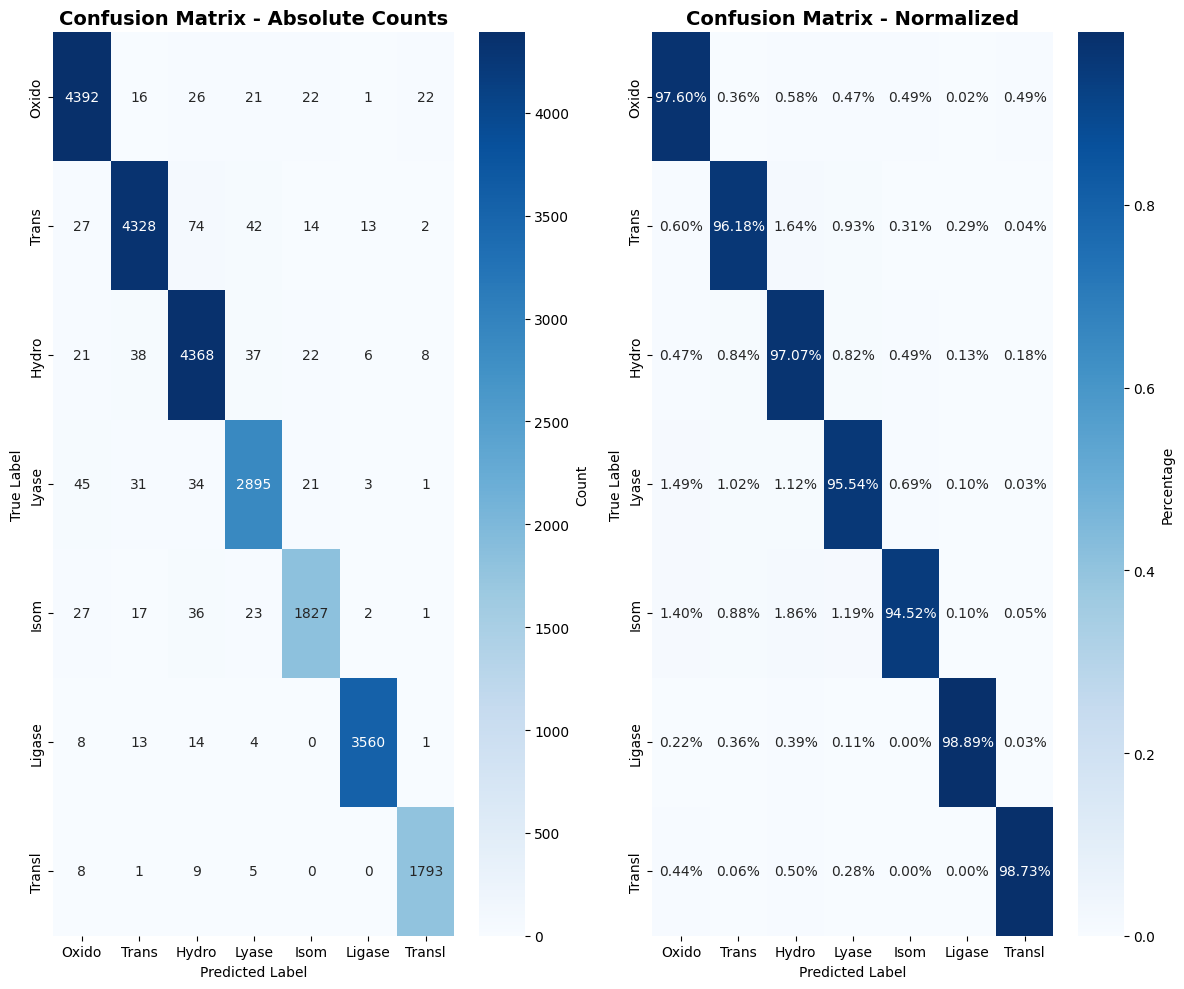

✓ Test confusion matrix saved to c:\Users\calam\repos\enzyme_classifier\results\figures\confusion_matrix_test.png


In [13]:
# Plot test confusion matrix (main result)
print("\n=== TEST SET CONFUSION MATRIX ===")

plt.figure(figsize=(12, 10))

# Absolute counts
plt.subplot(1, 2, 1)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ec_names_short, yticklabels=ec_names_short,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Absolute Counts', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized (percentages)
plt.subplot(1, 2, 2)
sns.heatmap(test_cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=ec_names_short, yticklabels=ec_names_short,
            cbar_kws={'label': 'Percentage'})
plt.title('Confusion Matrix - Normalized', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
fig_path = paths['results'] / 'figures' / 'confusion_matrix_test.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Test confusion matrix saved to {fig_path}")


=== VALIDATION SET CONFUSION MATRIX ===


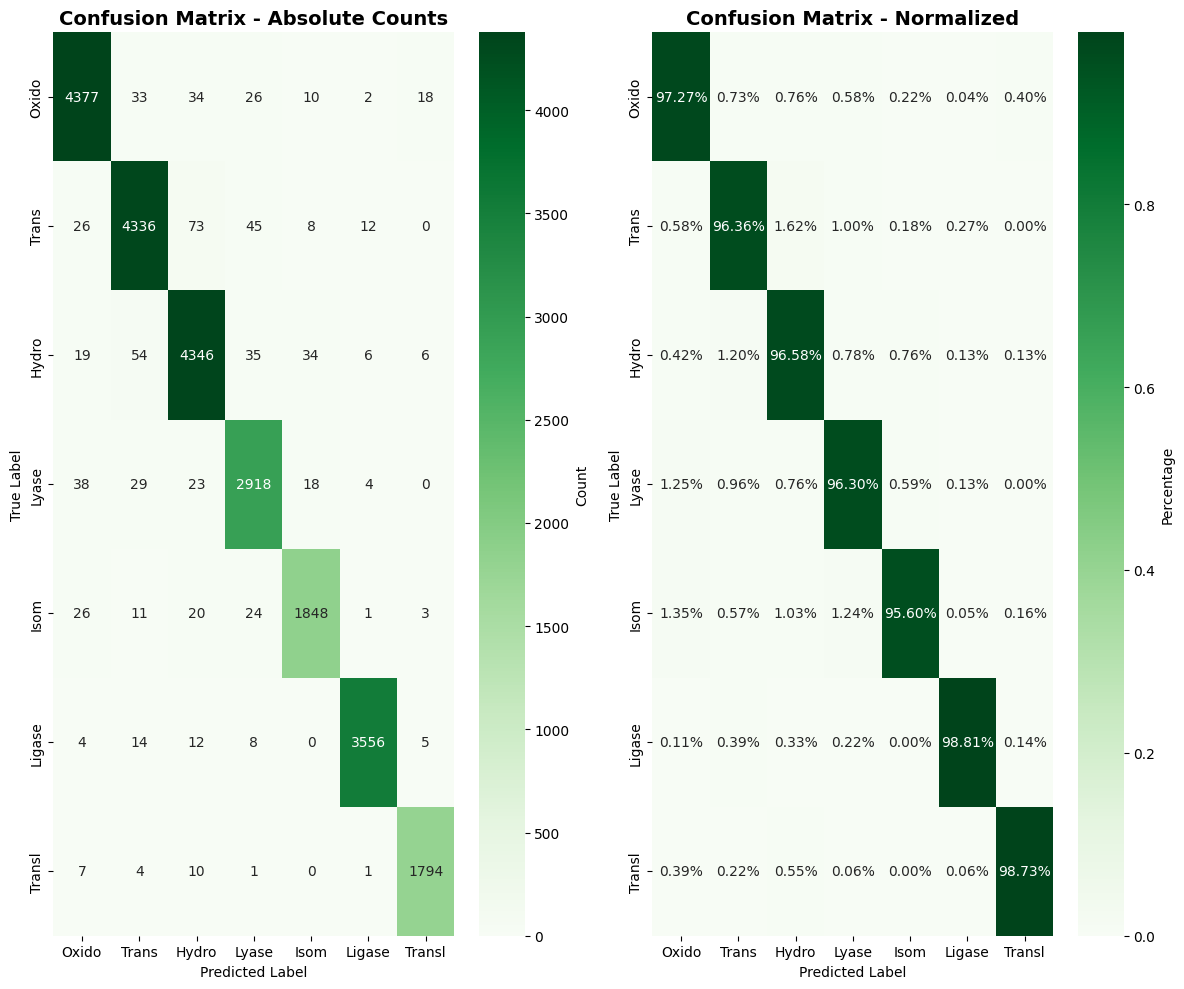

✓ Validation confusion matrix saved to c:\Users\calam\repos\enzyme_classifier\results\figures\confusion_matrix_val.png


In [14]:
# Plot validation confusion matrix
print("\n=== VALIDATION SET CONFUSION MATRIX ===")

plt.figure(figsize=(12, 10))

# Absolute counts
plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=ec_names_short, yticklabels=ec_names_short,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Absolute Counts', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized (percentages)
plt.subplot(1, 2, 2)
sns.heatmap(val_cm_norm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=ec_names_short, yticklabels=ec_names_short,
            cbar_kws={'label': 'Percentage'})
plt.title('Confusion Matrix - Normalized', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
fig_path = paths['results'] / 'figures' / 'confusion_matrix_val.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Validation confusion matrix saved to {fig_path}")

## 6. Per-Class Performance Analysis

In [15]:
# Calculate per-class metrics (precision, recall, F1)
print("\n=== PER-CLASS PERFORMANCE METRICS ===")

# Validation per-class metrics
val_precision, val_recall, val_f1, val_support = precision_recall_fscore_support(
    val_true_labels, val_pred_labels, average=None
)

# Test per-class metrics
test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(
    test_true_labels, test_pred_labels, average=None
)

# Create comprehensive DataFrames
val_perclass_df = pd.DataFrame({
    'Class': range(cfg['model']['num_labels']),
    'Class_Name': ec_names,
    'Precision': val_precision,
    'Recall': val_recall,
    'F1': val_f1,
    'Support': val_support
})

test_perclass_df = pd.DataFrame({
    'Class': range(cfg['model']['num_labels']),
    'Class_Name': ec_names,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1': test_f1,
    'Support': test_support
})

print("\nValidation Set - Per-Class Metrics:")
print(val_perclass_df.to_string(index=False))

print("\n\nTest Set - Per-Class Metrics:")
print(test_perclass_df.to_string(index=False))

# Save to CSV
val_perclass_path = paths['results'] / 'metrics' / 'perclass_metrics_val.csv'
test_perclass_path = paths['results'] / 'metrics' / 'perclass_metrics_test.csv'

val_perclass_df.to_csv(val_perclass_path, index=False)
test_perclass_df.to_csv(test_perclass_path, index=False)

print(f"\n✓ Validation per-class metrics saved to {val_perclass_path}")
print(f"✓ Test per-class metrics saved to {test_perclass_path}")


=== PER-CLASS PERFORMANCE METRICS ===

Validation Set - Per-Class Metrics:
 Class      Class_Name  Precision   Recall       F1  Support
     0 Oxidoreductases   0.973316 0.972667 0.972991     4500
     1    Transferases   0.967641 0.963556 0.965594     4500
     2      Hydrolases   0.961930 0.965778 0.963850     4500
     3          Lyases   0.954531 0.963036 0.958765     3030
     4      Isomerases   0.963504 0.956027 0.959751     1933
     5         Ligases   0.992741 0.988052 0.990391     3599
     6    Translocases   0.982475 0.987342 0.984903     1817


Test Set - Per-Class Metrics:
 Class      Class_Name  Precision   Recall       F1  Support
     0 Oxidoreductases   0.969965 0.976000 0.972973     4500
     1    Transferases   0.973897 0.961778 0.967800     4500
     2      Hydrolases   0.957685 0.970667 0.964132     4500
     3          Lyases   0.956392 0.955446 0.955919     3030
     4      Isomerases   0.958552 0.945163 0.951810     1933
     5         Ligases   0.993026 0.98

In [16]:
print("\n=== VISUALIZING PER-CLASS PERFORMANCE ===")

fig = go.Figure()

fig.add_trace(go.Bar(
    name='Precision',
    x=ec_names_short,
    y=test_perclass_df['Precision'],
    text=[f'{v:.3f}' for v in test_perclass_df['Precision']],
    textposition='auto',
))

fig.add_trace(go.Bar(
    name='Recall',
    x=ec_names_short,
    y=test_perclass_df['Recall'],
    text=[f'{v:.3f}' for v in test_perclass_df['Recall']],
    textposition='auto',
))

fig.add_trace(go.Bar(
    name='F1-Score',
    x=ec_names_short,
    y=test_perclass_df['F1'],
    text=[f'{v:.3f}' for v in test_perclass_df['F1']],
    textposition='auto',
))

fig.update_layout(
    title='Per-Class Performance Metrics (Test Set)',
    xaxis_title='Enzyme Class',
    yaxis_title='Score',
    yaxis=dict(range=[0, 1]),
    barmode='group',
    width=1000,
    height=500
)

fig.show()
print("✓ Per-class performance visualization complete")


=== VISUALIZING PER-CLASS PERFORMANCE ===


✓ Per-class performance visualization complete


In [17]:
# Identify best and worst performing classes
print("\n=== BEST AND WORST PERFORMING CLASSES ===")

sorted_by_f1 = test_perclass_df.sort_values('F1', ascending=False)

print("\nTop 3 Classes (by F1-Score):")
for idx, row in sorted_by_f1.head(3).iterrows():
    print(f"  {row['Class']}. {row['Class_Name']}: "
          f"P={row['Precision']:.4f}, R={row['Recall']:.4f}, F1={row['F1']:.4f}")

print("\nBottom 3 Classes (by F1-Score):")
for idx, row in sorted_by_f1.tail(3).iterrows():
    print(f"  {row['Class']}. {row['Class_Name']}: "
          f"P={row['Precision']:.4f}, R={row['Recall']:.4f}, F1={row['F1']:.4f}")

print("\n✓ Performance analysis complete")


=== BEST AND WORST PERFORMING CLASSES ===

Top 3 Classes (by F1-Score):
  5. Ligases: P=0.9930, R=0.9889, F1=0.9910
  6. Translocases: P=0.9809, R=0.9873, F1=0.9841
  0. Oxidoreductases: P=0.9700, R=0.9760, F1=0.9730

Bottom 3 Classes (by F1-Score):
  2. Hydrolases: P=0.9577, R=0.9707, F1=0.9641
  3. Lyases: P=0.9564, R=0.9554, F1=0.9559
  4. Isomerases: P=0.9586, R=0.9452, F1=0.9518

✓ Performance analysis complete


## 7. Error Analysis

In [18]:
# Analyze misclassifications
print("\n=== MISCLASSIFICATION ANALYSIS (TEST SET) ===")

# Find misclassified samples
misclassified_mask = test_pred_labels != test_true_labels
num_misclassified = misclassified_mask.sum()
total_samples = len(test_pred_labels)

print(f"\nTotal misclassifications: {num_misclassified:,} / {total_samples:,} ({num_misclassified/total_samples*100:.2f}%)")

# Get misclassified samples with details
misclassified_df = pd.DataFrame({
    'Index': np.where(misclassified_mask)[0],
    'True_Label': test_true_labels[misclassified_mask],
    'Pred_Label': test_pred_labels[misclassified_mask],
    'True_Class': [ec_names[label] for label in test_true_labels[misclassified_mask]],
    'Pred_Class': [ec_names[label] for label in test_pred_labels[misclassified_mask]],
    'Confidence': test_confidence[misclassified_mask]
})

print(f"\nMisclassified samples DataFrame shape: {misclassified_df.shape}")
print("\nFirst 10 misclassifications:")
print(misclassified_df.head(10).to_string(index=False))


=== MISCLASSIFICATION ANALYSIS (TEST SET) ===

Total misclassifications: 716 / 23,879 (3.00%)

Misclassified samples DataFrame shape: (716, 6)

First 10 misclassifications:
 Index  True_Label  Pred_Label      True_Class      Pred_Class  Confidence
     5           5           2         Ligases      Hydrolases    0.999991
    52           2           6      Hydrolases    Translocases    0.999255
    61           1           2    Transferases      Hydrolases    0.883955
    67           0           6 Oxidoreductases    Translocases    0.877354
    90           1           4    Transferases      Isomerases    0.486274
   122           3           0          Lyases Oxidoreductases    0.895291
   135           4           1      Isomerases    Transferases    0.966141
   178           1           2    Transferases      Hydrolases    0.999821
   188           3           0          Lyases Oxidoreductases    0.819555
   225           3           0          Lyases Oxidoreductases    0.996393


In [19]:
# Find most common error patterns
print("\n=== MOST COMMON ERROR PATTERNS ===")

error_pairs = misclassified_df.groupby(['True_Class', 'Pred_Class']).size().reset_index(name='Count')
error_pairs = error_pairs.sort_values('Count', ascending=False)

print("\nTop 10 confusion pairs:")
print(f"\n{'True Class':<20} {'Predicted As':<20} {'Count':>8} {'% of Errors':>12}")
print("-" * 65)

for idx, row in error_pairs.head(10).iterrows():
    pct = (row['Count'] / num_misclassified) * 100
    print(f"{row['True_Class']:<20} {row['Pred_Class']:<20} {row['Count']:>8} {pct:>11.2f}%")

# Save error analysis
error_pairs.to_csv('../results/metrics/error_patterns.csv', index=False)
misclassified_df.to_csv('../results/predictions/misclassified_samples.csv', index=False)

print("\n✓ Error patterns saved to results/metrics/error_patterns.csv")
print("✓ Misclassified samples saved to results/predictions/misclassified_samples.csv")


=== MOST COMMON ERROR PATTERNS ===

Top 10 confusion pairs:

True Class           Predicted As            Count  % of Errors
-----------------------------------------------------------------
Transferases         Hydrolases                 74       10.34%
Lyases               Oxidoreductases            45        6.28%
Transferases         Lyases                     42        5.87%
Hydrolases           Transferases               38        5.31%
Hydrolases           Lyases                     37        5.17%
Isomerases           Hydrolases                 36        5.03%
Lyases               Hydrolases                 34        4.75%
Lyases               Transferases               31        4.33%
Transferases         Oxidoreductases            27        3.77%
Isomerases           Oxidoreductases            27        3.77%

✓ Error patterns saved to results/metrics/error_patterns.csv
✓ Misclassified samples saved to results/predictions/misclassified_samples.csv


In [20]:
# Analyze prediction confidence
print("\n=== PREDICTION CONFIDENCE ANALYSIS ===")

# Compare confidence for correct vs incorrect predictions
correct_mask = ~misclassified_mask
correct_confidence = test_confidence[correct_mask]
incorrect_confidence = test_confidence[misclassified_mask]

print(f"\nCorrect predictions:")
print(f"  Mean confidence: {correct_confidence.mean():.4f}")
print(f"  Median confidence: {np.median(correct_confidence):.4f}")
print(f"  Std confidence: {correct_confidence.std():.4f}")

print(f"\nIncorrect predictions:")
print(f"  Mean confidence: {incorrect_confidence.mean():.4f}")
print(f"  Median confidence: {np.median(incorrect_confidence):.4f}")
print(f"  Std confidence: {incorrect_confidence.std():.4f}")

# Plot confidence distributions
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=correct_confidence,
    name='Correct',
    opacity=0.7,
    nbinsx=50
))

fig.add_trace(go.Histogram(
    x=incorrect_confidence,
    name='Incorrect',
    opacity=0.7,
    nbinsx=50
))

fig.update_layout(
    title='Prediction Confidence Distribution: Correct vs Incorrect',
    xaxis_title='Confidence Score',
    yaxis_title='Count',
    barmode='overlay',
    width=900,
    height=500
)

fig.show()
print("\n✓ Confidence analysis complete")


=== PREDICTION CONFIDENCE ANALYSIS ===

Correct predictions:
  Mean confidence: 0.9938
  Median confidence: 1.0000
  Std confidence: 0.0400

Incorrect predictions:
  Mean confidence: 0.8072
  Median confidence: 0.8716
  Std confidence: 0.1901



✓ Confidence analysis complete


In [21]:
# Examine low-confidence errors
print("\n=== LOW CONFIDENCE MISCLASSIFICATIONS ===")

# Sort misclassified by confidence
low_conf_errors = misclassified_df.sort_values('Confidence').head(20)

print("\nTop 20 lowest confidence errors:")
print(low_conf_errors[['True_Class', 'Pred_Class', 'Confidence']].to_string(index=False))

# High confidence errors (model was wrong but very confident)
high_conf_errors = misclassified_df.sort_values('Confidence', ascending=False).head(20)

print("\n=== HIGH CONFIDENCE MISCLASSIFICATIONS (Most Concerning) ===")
print("\nTop 20 highest confidence errors:")
print(high_conf_errors[['True_Class', 'Pred_Class', 'Confidence']].to_string(index=False))

print(f"\nNumber of high-confidence errors (>0.9): {(misclassified_df['Confidence'] > 0.9).sum()}")
print(f"Number of high-confidence errors (>0.8): {(misclassified_df['Confidence'] > 0.8).sum()}")


=== LOW CONFIDENCE MISCLASSIFICATIONS ===

Top 20 lowest confidence errors:
     True_Class      Pred_Class  Confidence
Oxidoreductases          Lyases    0.296100
         Lyases    Transferases    0.309997
     Isomerases          Lyases    0.312624
     Isomerases Oxidoreductases    0.336838
     Isomerases    Transferases    0.339755
Oxidoreductases      Hydrolases    0.342200
   Transferases Oxidoreductases    0.343319
Oxidoreductases          Lyases    0.348570
Oxidoreductases      Isomerases    0.359604
     Hydrolases      Isomerases    0.369084
     Isomerases    Transferases    0.372878
     Hydrolases Oxidoreductases    0.378361
        Ligases          Lyases    0.388034
         Lyases      Isomerases    0.388344
     Hydrolases          Lyases    0.390226
     Isomerases Oxidoreductases    0.395501
   Transferases          Lyases    0.395618
Oxidoreductases    Transferases    0.395882
     Hydrolases Oxidoreductases    0.400387
Oxidoreductases      Hydrolases    0.403968

## 8. Save Predictions & Summary

In [22]:
# Save all predictions
print("\n=== SAVING PREDICTIONS ===")

# Validation predictions
val_pred_df = pd.DataFrame({
    'True_Label': val_true_labels,
    'Pred_Label': val_pred_labels,
    'True_Class': [ec_names[label] for label in val_true_labels],
    'Pred_Class': [ec_names[label] for label in val_pred_labels],
    'Confidence': val_confidence,
    'Correct': val_true_labels == val_pred_labels
})

# Add probability for each class
for i, class_name in enumerate(ec_names):
    val_pred_df[f'Prob_{class_name}'] = val_probs[:, i]

val_pred_df.to_csv('../results/predictions/validation_predictions.csv', index=False)
print(f"✓ Validation predictions saved ({len(val_pred_df):,} samples)")

# Test predictions
test_pred_df = pd.DataFrame({
    'True_Label': test_true_labels,
    'Pred_Label': test_pred_labels,
    'True_Class': [ec_names[label] for label in test_true_labels],
    'Pred_Class': [ec_names[label] for label in test_pred_labels],
    'Confidence': test_confidence,
    'Correct': test_true_labels == test_pred_labels
})

# Add probability for each class
for i, class_name in enumerate(ec_names):
    test_pred_df[f'Prob_{class_name}'] = test_probs[:, i]

test_pred_df.to_csv('../results/predictions/test_predictions.csv', index=False)
print(f"✓ Test predictions saved ({len(test_pred_df):,} samples)")


=== SAVING PREDICTIONS ===
✓ Validation predictions saved (23,879 samples)
✓ Test predictions saved (23,879 samples)


In [23]:
# Generate comprehensive summary report
print("\n=== GENERATING SUMMARY REPORT ===")

summary_report = f"""
{'='*80}
ENZYME CLASSIFICATION MODEL - EVALUATION SUMMARY
{'='*80}

Model: {cfg['model']['name']}
Training: LoRA Fine-tuning
Number of Classes: {cfg['model']['num_labels']}

{'='*80}
OVERALL PERFORMANCE
{'='*80}

Validation Set ({len(val_ds):,} samples):
  Accuracy:         {val_accuracy:.4f}
  Macro Precision:  {val_macro_precision:.4f}
  Macro Recall:     {val_macro_recall:.4f}
  Macro F1:         {val_macro_f1:.4f}
  Micro Precision:  {val_micro_precision:.4f}
  Micro Recall:     {val_micro_recall:.4f}
  Micro F1:         {val_micro_f1:.4f}

Test Set ({len(test_ds):,} samples):
  Accuracy:         {test_accuracy:.4f}
  Macro Precision:  {test_macro_precision:.4f}
  Macro Recall:     {test_macro_recall:.4f}
  Macro F1:         {test_macro_f1:.4f}
  Micro Precision:  {test_micro_precision:.4f}
  Micro Recall:     {test_micro_recall:.4f}
  Micro F1:         {test_micro_f1:.4f}

{'='*80}
PER-CLASS PERFORMANCE (Test Set)
{'='*80}

{'Class':<5} {'Name':<20} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}
{'-'*80}
"""

for idx, row in test_perclass_df.iterrows():
    summary_report += f"\n{row['Class']:<5} {row['Class_Name']:<20} "
    summary_report += f"{row['Precision']:>10.4f} {row['Recall']:>10.4f} "
    summary_report += f"{row['F1']:>10.4f} {row['Support']:>10.0f}"

summary_report += f"""

{'='*80}
BEST PERFORMING CLASSES (by F1-Score)
{'='*80}
"""

for idx, row in sorted_by_f1.head(3).iterrows():
    summary_report += f"\n{row['Class']}. {row['Class_Name']}: "
    summary_report += f"P={row['Precision']:.4f}, R={row['Recall']:.4f}, F1={row['F1']:.4f}"

summary_report += f"""

{'='*80}
WORST PERFORMING CLASSES (by F1-Score)
{'='*80}
"""

for idx, row in sorted_by_f1.tail(3).iterrows():
    summary_report += f"\n{row['Class']}. {row['Class_Name']}: "
    summary_report += f"P={row['Precision']:.4f}, R={row['Recall']:.4f}, F1={row['F1']:.4f}"

summary_report += f"""

{'='*80}
OUTPUT FILES
{'='*80}

Predictions:
  - results/predictions/validation_predictions.csv
  - results/predictions/test_predictions.csv
  - results/predictions/misclassified_samples.csv

Metrics:
  - results/metrics/overall_metrics.csv
  - results/metrics/perclass_metrics_val.csv
  - results/metrics/perclass_metrics_test.csv
  - results/metrics/error_patterns.csv

Figures:
  - results/figures/confusion_matrix_test.png
  - results/figures/confusion_matrix_val.png

{'='*80}
END OF REPORT
{'='*80}
"""

# Save summary report
with open('../results/evaluation_summary.txt', 'w') as f:
    f.write(summary_report)

print(summary_report)
print("\n✓ Summary report saved to results/evaluation_summary.txt")


=== GENERATING SUMMARY REPORT ===

ENZYME CLASSIFICATION MODEL - EVALUATION SUMMARY

Model: facebook/esm2_t12_35M_UR50D
Training: LoRA Fine-tuning
Number of Classes: 7

OVERALL PERFORMANCE

Validation Set (23,879 samples):
  Accuracy:         0.9705
  Macro Precision:  0.9709
  Macro Recall:     0.9709
  Macro F1:         0.9709
  Micro Precision:  0.9705
  Micro Recall:     0.9705
  Micro F1:         0.9705

Test Set (23,879 samples):
  Accuracy:         0.9700
  Macro Precision:  0.9701
  Macro Recall:     0.9693
  Macro F1:         0.9697
  Micro Precision:  0.9700
  Micro Recall:     0.9700
  Micro F1:         0.9700

PER-CLASS PERFORMANCE (Test Set)

Class Name                  Precision     Recall         F1    Support
--------------------------------------------------------------------------------

0     Oxidoreductases          0.9700     0.9760     0.9730       4500
1     Transferases             0.9739     0.9618     0.9678       4500
2     Hydrolases               0.9577   